In [1]:
# task 4.1. Реализовать BiRNN & LSTM по предсказанию цены Bitcoin (или можете взять любой другой финансовый инструмент)

In [1]:
import pandas as pd

In [6]:
data = pd.read_csv('BTC-2021min.csv')
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646106180,2022-03-01 03:43:00,BTC/USD,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
1,1646106060,2022-03-01 03:41:00,BTC/USD,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2,1646106000,2022-03-01 03:40:00,BTC/USD,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
3,1646105940,2022-03-01 03:39:00,BTC/USD,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
4,1646105880,2022-03-01 03:38:00,BTC/USD,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143


Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0084
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0013
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 9.5884e-04
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 8.8950e-04
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.3686e-04
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 7.1309e-04
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.9089e-04
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 7.0429e-04
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.8826e-04
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.0820e-04
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


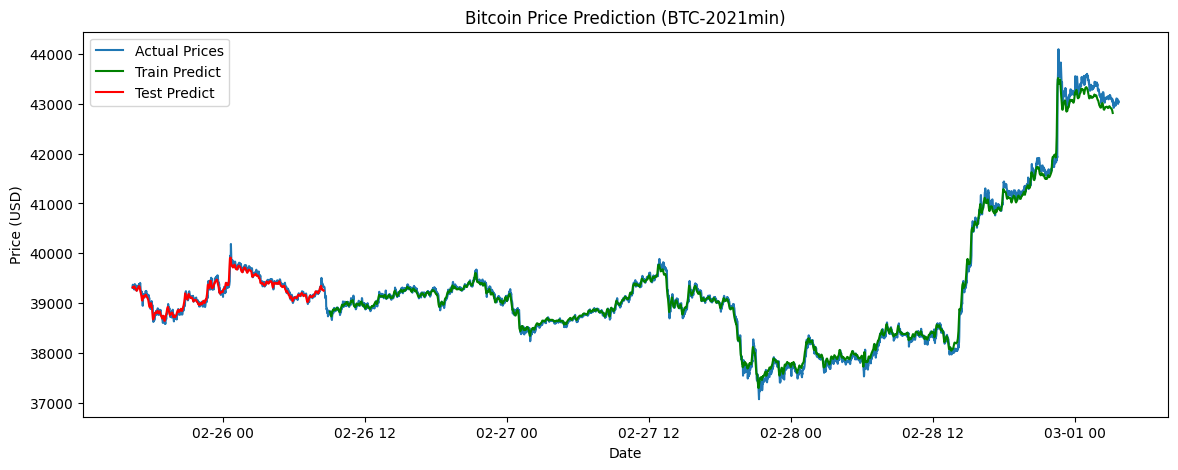

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Input
import matplotlib.pyplot as plt

# 1. Загрузка данных
data_path = r'C:\Users\285\Desktop\data_science\HomeWork13 DL 4 lesson'
file = 'BTC-2021min.csv'

df = pd.read_csv(os.path.join(data_path, file))

# Преобразование столбца 'date' в datetime и установка его индексом
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 2. Уменьшение размера данных для ускорения (берем первые 5000 строк)
df = df.head(5000)

# Выбираем только цену закрытия
data = df[['close']]

# Масштабируем данные
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Разделение на тренировочные и тестовые данные (80% для обучения)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Функция для создания наборов данных с временным шагом
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Уменьшение временного шага до 30 для ускорения
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Изменяем форму данных для модели LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Построение модели BiRNN с LSTM и исправление предупреждения
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. Обучение модели с уменьшенным количеством эпох (например, 10) и размером батча 16
model.fit(X_train, y_train, epochs=10, batch_size=16)

# 6. Предсказание
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное масштабирование
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Восстановление данных для графиков
train_data_plot = np.empty_like(scaled_data)
train_data_plot[:, :] = np.nan
train_data_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_data_plot = np.empty_like(scaled_data)
test_data_plot[:, :] = np.nan
test_data_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# 7. Визуализация результатов
plt.figure(figsize=(14, 5))
plt.plot(df.index, scaler.inverse_transform(scaled_data), label='Actual Prices')
plt.plot(df.index, train_data_plot, label='Train Predict', color='green')
plt.plot(df.index, test_data_plot, label='Test Predict', color='red')
plt.legend()
plt.title('Bitcoin Price Prediction (BTC-2021min)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()
